In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd 
import os
import shutil
import cv2
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
import keras.utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.utils import to_categorical

 

In [2]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [3]:
data_folder = r"C:\Users\Admin\Documents\TESI DATASET\dataset_definitivo\train_test_validation"
image_dir = r"C:\Users\Admin\Documents\TESI DATASET\dataset_definitivo\train_test_validation\train_validation"


In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
df = pd.read_csv(data_folder + '\list_partition.csv')
df = df.drop('Unnamed: 0', axis=1)
df['gender'].value_counts()

gender
0    3843
2    3773
1    3751
Name: count, dtype: int64

In [6]:
EPOCHS = 5
N_SPLIT = 5 

#storing the average of all predictions 
main_pred = []
data_kfold = pd.DataFrame() 

#Creating X, Y for training 
train_y = df['gender']
train_x = df['image']

In [7]:
#Initializing Data Generators 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
#KFold 
kf = StratifiedKFold(n_splits = N_SPLIT, shuffle = True, random_state = 42) 

In [9]:
Y = df[['gender']]

In [10]:
# Convert integer labels to string labels using .loc
Y.loc[:, 'gender'] = Y['gender'].astype(str)

# Verify the data type of the 'gender' column
print(Y['gender'].dtype)

object


In [11]:
y_val = Y.iloc[10]


In [12]:
# Convert integer labels to string labels using .loc
df.loc[:, 'gender'] = df['gender'].astype(str)

# Verify the data type of the 'gender' column
print(df['gender'].dtype)

object


In [13]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [14]:
batch_size = 64
target_size = (224, 224)
input_shape=(224, 224, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001

In [15]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

import efficientnet.keras as efn
import tensorflow

In [16]:
models_directory = r"C:\Users\Admin\Documents\TESI\models" 

In [18]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in kf.split(np.zeros(train_x.shape[0]),Y):

    print("--------------------")
    print("Fold:", fold_var) 
    
    training_data = df.iloc[train_index]
    validation_data = df.iloc[val_index]
    
    train_data_generator = train_datagen.flow_from_dataframe(training_data, directory = image_dir,
                               x_col = "image", y_col = "gender",
                               class_mode = "categorical", shuffle = True, target_size = (224, 224))
    valid_data_generator  = validation_datagen.flow_from_dataframe(validation_data, directory = image_dir,
                            x_col = "image", y_col = "gender",
                            class_mode = "categorical", shuffle = True, target_size = (224, 224))
    
    # CREATE NEW MODEL
    model = Sequential()    
    
    #BUILD MODEL - GENDER RECOGNITION 
    # Import InceptionV3 Model
    pretrained_model = InceptionV3(weights= 'imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3))
    
    for layer in pretrained_model.layers[:-5]:
        layer.trainable=False
    
    model.add(pretrained_model)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    #model = Model(base_model.input, predictions)
    
    #Compile the model 
    model.compile(optimizer= "adam", loss="categorical_crossentropy",metrics=['accuracy'])

    """
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                            monitor='val_accuracy', verbose=1, 
                            save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    """
    
    # Model Checkpoint
    model_path='./output/inceptionv3.h5'
    checkpointer = ModelCheckpoint(model_path, monitor='loss',verbose=1,save_best_only=True,
                                   save_weights_only=False, mode='auto',save_freq='epoch')
    callback_list=[checkpointer]
    
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(train_data_generator,
                epochs=EPOCHS,
                callbacks=callback_list,
                validation_data=valid_data_generator)
    #PLOT HISTORY
    #		:
    #		:
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights("./output/inceptionv3.h5")
    
    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names,results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

--------------------
Fold: 1
Found 7731 validated image filenames belonging to 3 classes.
Found 1950 validated image filenames belonging to 3 classes.


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1362 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 324 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5
242/242 [==============================] - ETA: 0s - loss: 2.5615 - accuracy: 0.8595
Epoch 1: loss improved from inf to 2.56152, saving model to ./output\inceptionv3.h5


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 [==============================] - 321s 1s/step - loss: 2.5615 - accuracy: 0.8595 - val_loss: 1.0337 - val_accuracy: 0.8749
Epoch 2/5
242/242 [==============================] - ETA: 0s - loss: 0.3861 - accuracy: 0.9117
Epoch 2: loss improved from 2.56152 to 0.38606, saving model to ./output\inceptionv3.h5
242/242 [==============================] - 315s 1s/step - loss: 0.3861 - accuracy: 0.9117 - val_loss: 0.2159 - val_accuracy: 0.9179
Epoch 3/5
242/242 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9426
Epoch 3: loss improved from 0.38606 to 0.15301, saving model to ./output\inceptionv3.h5
242/242 [==============================] - 309s 1s/step - loss: 0.1530 - accuracy: 0.9426 - val_loss: 0.2324 - val_accuracy: 0.9231
Epoch 4/5
242/242 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9430
Epoch 4: loss improved from 0.15301 to 0.15192, saving model to ./output\inceptionv3.h5
242/242 [==============================] - 312s 1s/step

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1358 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 328 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5
242/242 [==============================] - ETA: 0s - loss: 3.0463 - accuracy: 0.8399
Epoch 1: loss improved from inf to 3.04631, saving model to ./output\inceptionv3.h5


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 [==============================] - 314s 1s/step - loss: 3.0463 - accuracy: 0.8399 - val_loss: 0.5195 - val_accuracy: 0.8926
Epoch 2/5
242/242 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.9235
Epoch 2: loss improved from 3.04631 to 0.26468, saving model to ./output\inceptionv3.h5
242/242 [==============================] - 310s 1s/step - loss: 0.2647 - accuracy: 0.9235 - val_loss: 0.2386 - val_accuracy: 0.9203
Epoch 3/5
242/242 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.9289
Epoch 3: loss improved from 0.26468 to 0.19185, saving model to ./output\inceptionv3.h5
242/242 [==============================] - 312s 1s/step - loss: 0.1919 - accuracy: 0.9289 - val_loss: 0.1839 - val_accuracy: 0.9322
Epoch 4/5
242/242 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9473
Epoch 4: loss improved from 0.19185 to 0.14660, saving model to ./output\inceptionv3.h5
242/242 [==============================] - 311s 1s/step

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1365 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 321 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5
242/242 [==============================] - ETA: 0s - loss: 2.6726 - accuracy: 0.8419
Epoch 1: loss improved from inf to 2.67264, saving model to ./output\inceptionv3.h5


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 [==============================] - 316s 1s/step - loss: 2.6726 - accuracy: 0.8419 - val_loss: 0.2779 - val_accuracy: 0.9032
Epoch 2/5
242/242 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9269
Epoch 2: loss improved from 2.67264 to 0.20738, saving model to ./output\inceptionv3.h5
242/242 [==============================] - 311s 1s/step - loss: 0.2074 - accuracy: 0.9269 - val_loss: 0.1987 - val_accuracy: 0.9273
Epoch 3/5
242/242 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9363
Epoch 3: loss improved from 0.20738 to 0.17551, saving model to ./output\inceptionv3.h5
242/242 [==============================] - 312s 1s/step - loss: 0.1755 - accuracy: 0.9363 - val_loss: 0.2389 - val_accuracy: 0.9129
Epoch 4/5
242/242 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9392
Epoch 4: loss improved from 0.17551 to 0.16180, saving model to ./output\inceptionv3.h5
242/242 [==============================] - 308s 1s/step

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1336 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 350 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5
243/243 [==============================] - ETA: 0s - loss: 3.2534 - accuracy: 0.8407
Epoch 1: loss improved from inf to 3.25342, saving model to ./output\inceptionv3.h5


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


243/243 [==============================] - 321s 1s/step - loss: 3.2534 - accuracy: 0.8407 - val_loss: 0.2051 - val_accuracy: 0.9329
Epoch 2/5
243/243 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9236
Epoch 2: loss improved from 3.25342 to 0.21386, saving model to ./output\inceptionv3.h5
243/243 [==============================] - 322s 1s/step - loss: 0.2139 - accuracy: 0.9236 - val_loss: 0.1838 - val_accuracy: 0.9262
Epoch 3/5
243/243 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9415
Epoch 3: loss improved from 0.21386 to 0.16305, saving model to ./output\inceptionv3.h5
243/243 [==============================] - 323s 1s/step - loss: 0.1631 - accuracy: 0.9415 - val_loss: 0.1843 - val_accuracy: 0.9345
Epoch 4/5
243/243 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9379
Epoch 4: loss did not improve from 0.16305
243/243 [==============================] - 322s 1s/step - loss: 0.1663 - accuracy: 0.9379 - val_loss

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1323 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 363 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5
243/243 [==============================] - ETA: 0s - loss: 2.7893 - accuracy: 0.8541
Epoch 1: loss improved from inf to 2.78926, saving model to ./output\inceptionv3.h5


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


243/243 [==============================] - 314s 1s/step - loss: 2.7893 - accuracy: 0.8541 - val_loss: 0.7328 - val_accuracy: 0.8838
Epoch 2/5
243/243 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.9188
Epoch 2: loss improved from 2.78926 to 0.32990, saving model to ./output\inceptionv3.h5
243/243 [==============================] - 310s 1s/step - loss: 0.3299 - accuracy: 0.9188 - val_loss: 0.2827 - val_accuracy: 0.9084
Epoch 3/5
243/243 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9355
Epoch 3: loss improved from 0.32990 to 0.18389, saving model to ./output\inceptionv3.h5
243/243 [==============================] - 309s 1s/step - loss: 0.1839 - accuracy: 0.9355 - val_loss: 0.2395 - val_accuracy: 0.9204
Epoch 4/5
243/243 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9421
Epoch 4: loss improved from 0.18389 to 0.16525, saving model to ./output\inceptionv3.h5
243/243 [==============================] - 309s 1s/step

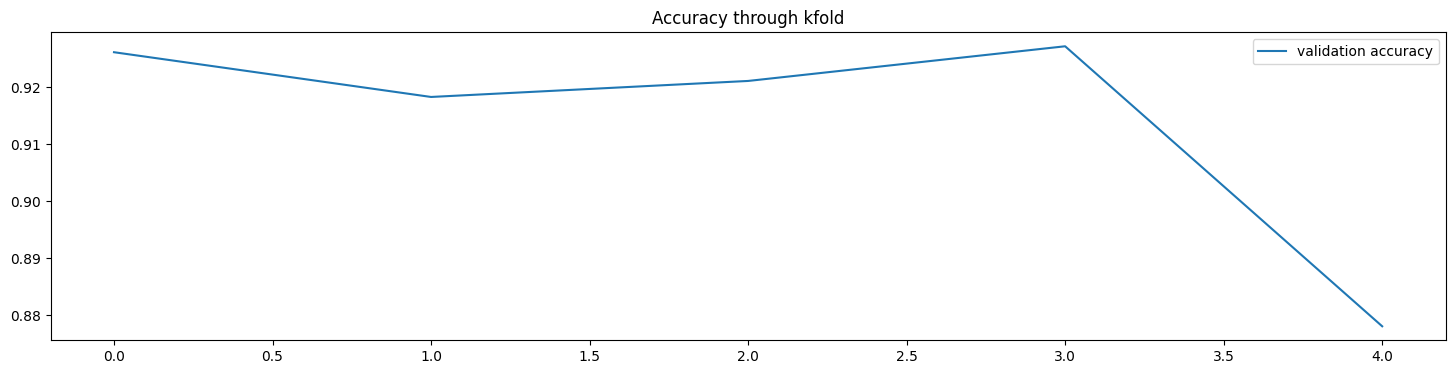

In [19]:
plt.figure(figsize=(18, 4))
plt.plot(VALIDATION_ACCURACY, label = 'validation accuracy')
plt.legend()
plt.title('Accuracy through kfold')
plt.show()

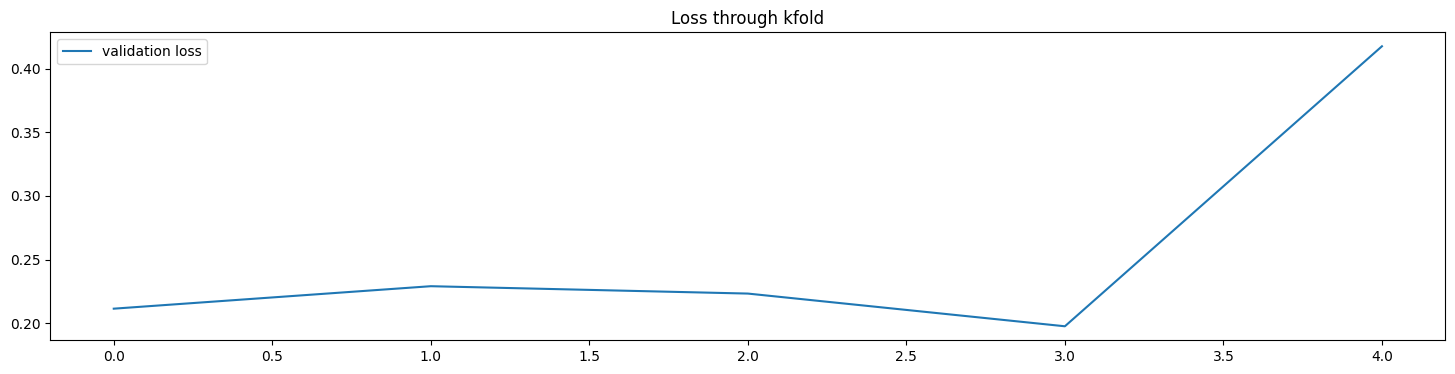

In [20]:
plt.figure(figsize=(18, 4))
plt.plot(VALIDATION_LOSS, label = 'validation loss')
plt.legend()
plt.title('Loss through kfold')
plt.show()

In [6]:
# CREATE NEW MODEL
model = Sequential()    
    
#BUILD MODEL - GENDER RECOGNITION 
# Import InceptionV3 Model
pretrained_model = InceptionV3(weights= 'imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))
    
for layer in pretrained_model.layers[:-5]:
    layer.trainable=False
    
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [7]:
# LOAD BEST MODEL to evaluate the performance of the model
model.load_weights("./output/inceptionv3.h5")

In [8]:
partition_df = pd.read_csv(r"C:\Users\Admin\Documents\TESI DATASET\dataset_definitivo\train_test_validation\list_partition.csv")

train_df = partition_df.loc[partition_df['partition'] == 0]
validation_df = partition_df.loc[partition_df['partition'] == 1]
test_df = partition_df.loc[partition_df['partition'] == 2]

train_df = train_df.drop('Unnamed: 0', axis=1)
test_df = test_df.drop('Unnamed: 0', axis=1)
validation_df = validation_df.drop('Unnamed: 0', axis=1)

In [9]:
from skimage import io

In [17]:
test_folder = r"C:\Users\Admin\Documents\TESI DATASET\dataset_definitivo\train_test_validation\test\\" 

def generate_df(attr):
    x_ = []
    y_ = []

    for index, target in test_df.iterrows():
        im = io.imread(test_folder + target['image'])
        #im = cv2.imread(r"C:\Users\Admin\Documents\TESI DATASET\balanced dataset\img_predictions" + target['image_id'])
        im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (224, 224)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)
        x_.append(im)
        y_.append(target[attr])

    return x_, y_

In [18]:
# Test Data
from sklearn.metrics import f1_score
x_test, y_test = generate_df('gender')

# generate prediction
model_predictions = [np.argmax(model.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions, average='weighted'))

1/1 [==============================] - 0s 81ms/step
Model Evaluation
Test accuracy: 81.3760%
f1_score: 0.813471159667061


In [20]:
from sklearn import metrics
print("Accuracy score:{:.2f}".format(metrics.accuracy_score(y_test, model_predictions)))
print("Classification Results:\n{}".format(metrics.classification_report(y_test, model_predictions)))

Accuracy score:0.81
Classification Results:
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       599
           1       0.94      0.73      0.82       558
           2       0.96      0.69      0.80       529

    accuracy                           0.81      1686
   macro avg       0.86      0.81      0.81      1686
weighted avg       0.86      0.81      0.81      1686



In [21]:
print(metrics.confusion_matrix(y_test, model_predictions)) 

[[598   1   0]
 [135 407  16]
 [135  27 367]]


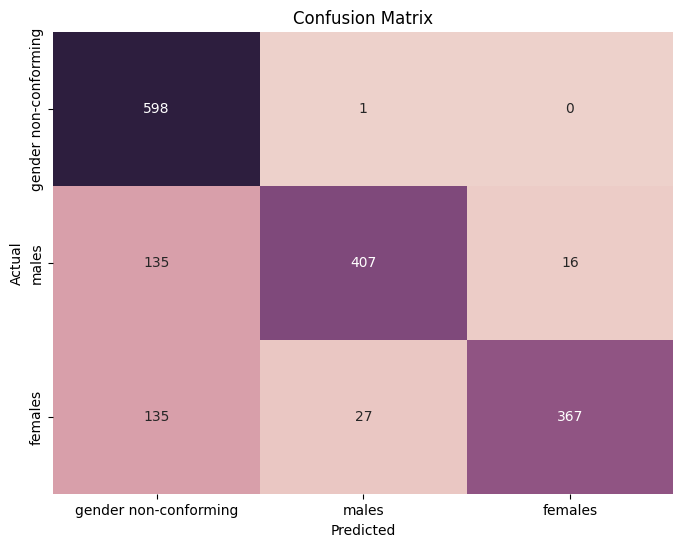

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(metrics.confusion_matrix(y_test, model_predictions), annot=True, fmt = 'd', cmap=sns.cubehelix_palette(as_cmap=True), 
            cbar=False, 
            xticklabels=['gender non-conforming', 'males', 'females'], 
            yticklabels =['gender non-conforming', 'males', 'females']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [31]:
import lime
import lime.lime_tabular

In [32]:
X_train = train_gen.flow_from_directory((r"C:\Users\Admin\Documents\TESI DATASET\new_dataset\dataset_images\folder_of_images\train"), target_size=(224,224), batch_size=32)
X_test = test_gen.flow_from_directory((r"C:\Users\Admin\Documents\TESI DATASET\new_dataset\dataset_images\folder_of_images\test"), target_size=(224,224), batch_size=32)
y_train = train_df['gender'] 
y_test = test_df['gender']

NameError: name 'train_gen' is not defined

In [33]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
%matplotlib inline



def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        out.append(x)
    return np.vstack(out)
    
images = transform_img_fn([r"C:\Users\Admin\Documents\TESI DATASET\dataset_train_test\test\005066.jpg"])

In [34]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    images[0].astype('double'), 
    model.predict, 
    top_labels=30, 
    hide_color=0, 
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 306ms/step


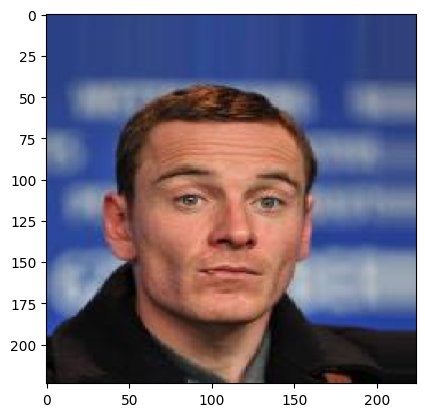

In [35]:
plt.imshow(images[0].astype("uint8"))

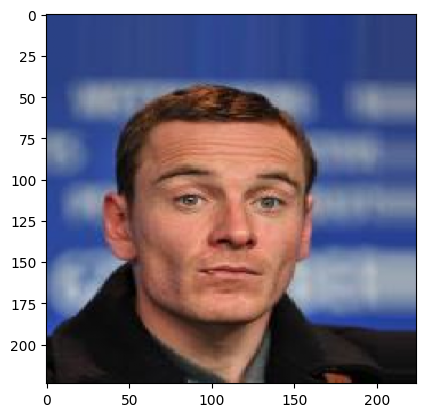

In [36]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=12, hide_rest=False)
plt.imshow(mark_boundaries(temp.astype("uint8"), mask))

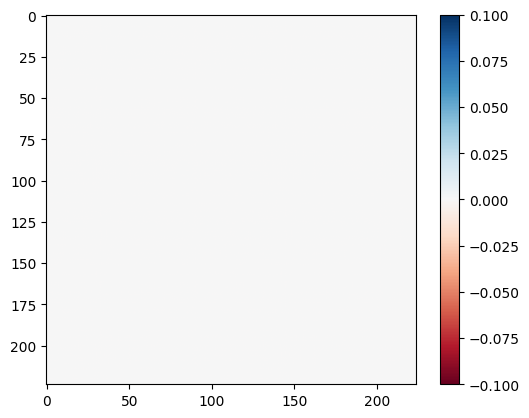

In [37]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [38]:
explanation.top_labels

[0, 2, 1]